In [1]:
import numpy as np
import cv2
import glob
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import math
from collections import defaultdict
import operator
import heapq


%matplotlib inline

## Camera Calibration

In [2]:
check_imgs = ["camera_cal/calibration"+str(i)+".jpg" for i in range(1,21)]
grid_sizes = [(9,5),(9,6),(9,6),(6,5),(7,6)]+ [(9,6)]*15

def calibration_matrix(imgs, grid_sizes):
    objpoints = []
    imgpoints = []
    for idx, fname in enumerate(imgs):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        grid_size = grid_sizes[idx]
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, grid_size, None)

        # If found, add object points, image points
        if ret == True:
            objp = np.zeros((grid_size[0]*grid_size[1],3), np.float32)
            objp[:,:2] = np.mgrid[0:grid_size[0], 0:grid_size[1]].T.reshape(-1,2)

            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
#             cv2.drawChessboardCorners(img, grid_size, corners, ret)
#             write_name = 'camera_cal/corners_found'+str(idx+1)+'.jpg'
#             cv2.imwrite(write_name, img)
    #         cv2.imshow('img', img)
    #         cv2.waitKey(500)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return (mtx,dist)

mtx, dist = calibration_matrix(check_imgs,grid_sizes)

## Transformation to Birdview

In [4]:
img_size = (720,720)

def perspective_transformation(target_img_size):
    src = np.array([[592, 453], 
                    [695,453],
                    [970, 630],
                    [348, 630]], dtype = "float32")

    h_margin = 200
    top_margin = 200
    bottom_margin = 50
    dst = np.array([[h_margin, top_margin], 
                    [target_img_size[0] - h_margin, top_margin],
                    [target_img_size[0] - h_margin, target_img_size[1] - bottom_margin],
                    [h_margin, target_img_size[1] - bottom_margin]], dtype = "float32")
    return cv2.getPerspectiveTransform(src, dst)

M = perspective_transformation(img_size)
M_inv = np.linalg.inv(M)

## Define Mask

This is how the mask looks like on the birdview image


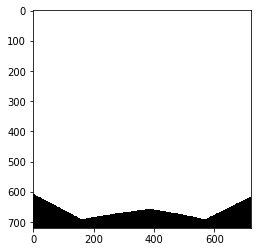

In [541]:
def region_of_interest(shape, vertices):
    #defining a blank mask to start with
    mask = np.zeros(shape,dtype=np.uint8)
    cv2.fillPoly(mask, np.array([vertices], dtype=np.int32),1)
    return mask
roi = region_of_interest((720,1280), [[300,420],[200,670],[700,600],[1150,670],[1000,420]])
roi = cv2.undistort(roi, mtx, dist, None, mtx)
roi = cv2.warpPerspective(roi, M, img_size, flags=cv2.INTER_LINEAR)
print("This is how the mask looks like on the birdview image")
plt.imshow(roi,cmap='gray')

This is how the mask looks like on the original image


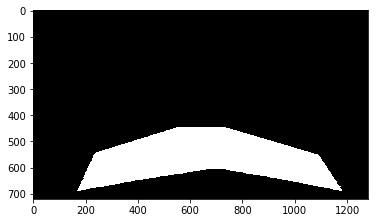

In [542]:
test = cv2.warpPerspective(roi, np.linalg.inv(M), (1280,720), flags=cv2.INTER_LINEAR)
print("This is how the mask looks like on the original image")
plt.imshow(test,cmap='gray')

## The Lane Class
also available in Lane.py

In [533]:
class Lane:
    def __init__(self, img_size, convert_x, convert_y,
                 smooth_window=5, poly_fit_thres=10, default_lane_width=300):
        self.left_detected = False
        self.right_detected = False
        self.img_size = img_size
        self.width = default_lane_width # Lane width
        # y coodinates, will be used to plot polynomial
        self.ploty = np.linspace(0, img_size[0]-1, img_size[0]).astype('int64')
        self.left_x = np.array([], dtype=np.int64)
        self.left_y = np.array([], dtype=np.int64)
        self.right_x = np.array([], dtype=np.int64)
        self.right_y = np.array([], dtype=np.int64)
        
        # fitting data
        self.poly_fit_thres = poly_fit_thres # for error checking
        self.left_poly = [] # [c2,c1,c0] coeffecients of the left lane polynomial
        self.right_poly = [] # [c2,c1,c0] coeffecients of the right lane polynomial
        ## err of the poly fitting
        self.left_polyfit_err = 0 # err for left polynomial fitting.
        self.right_polyfit_err = 0 # err for right polynomial fitting.
        
        ## past_left_fitx and past_right_fitx store fitted lane curve in the past n frame
        ## while n=smooth_window is the smoothing window size
        self.past_left_fitx = np.array([[np.nan]*smooth_window]*img_size[0])
        self.past_right_fitx = np.array([[np.nan]*smooth_window]*img_size[0])
        ## left_fitx and right_fitx store the average result from past_left_fitx and past_right_fitx
        self.left_fitx = None
        self.right_fitx = None
        
        # constants used to convert from pixels to meters
        self.convert_x = convert_x
        self.convert_y = convert_y
        
        # canvas to draw the analyzed results
        self.canvas = np.zeros((self.img_size[0],self.img_size[1],3),dtype=np.uint8)
        
    def reset_canvas(self):
        self.canvas[:,:,:] = 0 # reset to blank
        self.left_x = np.array([], dtype=np.int64)
        self.left_y = np.array([], dtype=np.int64)
        self.right_x = np.array([], dtype=np.int64)
        self.right_y = np.array([], dtype=np.int64)
        self.left_poly = []
        self.right_poly = []
        
    def polyfit_left(self):
        # Shift past_left_fitx to the left so that the last column can be used to 
        # store the new fitted x coordinates (of the left lane polynomial)
        self.past_left_fitx = np.roll(self.past_left_fitx,shift=(0,-1))
        self.past_left_fitx[:,-1] = np.nan
        self.left_detected = False
       
        if self.left_x.size==0: return False  # if no pixel to fit, return False
        # Fit a second order polynomial
        self.left_poly = np.polyfit(self.left_y, self.left_x, 2)
        
        # Error check 1:
        ## compute the difference between the x coordinates of the detected lane pixels 
        ## and the fitted polynomial
        diff = np.abs((self.left_poly[0]*self.left_y**2 + 
                      self.left_poly[1]*self.left_y + 
                      self.left_poly[2]).astype('int64')-self.left_x)
        ## remove outliers: if a pixel is located more than the median of the difference
        ## max(.,10): if median is too small, then there is no outlier, 
        outlier_mask = (diff<max(np.median(diff),10))
        ## filter out outliers
        self.left_y = self.left_y[outlier_mask]
        self.left_x = self.left_x[outlier_mask]
        diff = diff[outlier_mask]
        ## polyfit_err is the mean err after filtering outliers
        self.left_polyfit_err = diff.mean() if diff.size>0 else self.poly_fit_thres + 1
        if self.left_polyfit_err>self.poly_fit_thres: 
            return False
                
        # compute the fitted curve
        left_fitx = (self.left_poly[0]*self.ploty**2 + 
                     self.left_poly[1]*self.ploty + 
                     self.left_poly[2]).astype('int64')
        
        # Error check 2: check left-right curve distance.
        if self.right_fitx is not None:
            lane_checker = self.right_fitx-left_fitx
            mean_width = lane_checker.mean()
            ## if left lane line intersects with right line
            ## or the average lane width is too narrow
            ## then fail the checker
            if (lane_checker<0).any() or mean_width<100:
                print("failed lane_checker")
                return False
            else:
                self.width = mean_width
                
        # trim the pixels that run out of the canvas
        left_fitx[left_fitx<0]=0
        left_fitx[left_fitx>img_size[0]-1]=img_size[0]-1
        self.past_left_fitx[:,-1] = left_fitx
        self.left_fitx = np.nanmean(self.past_left_fitx, axis=1).astype('int64')
        self.left_detected = True
        return True
            
    def polyfit_right(self):
        # similar to polyfit_left
        self.past_right_fitx = np.roll(self.past_right_fitx,shift=(0,-1))
        self.past_right_fitx[:,-1] = np.nan
        self.right_detected = False
        if self.right_x.size==0: return False
        # Fit a second order polynomial
        self.right_poly = np.polyfit(self.right_y, self.right_x, 2)
        diff = np.abs((self.right_poly[0]*self.right_y**2 + 
                      self.right_poly[1]*self.right_y + 
                      self.right_poly[2]).astype('int64')-self.right_x)
        outlier_mask = (diff<max(np.median(diff),10))
        self.right_y = self.right_y[outlier_mask]
        self.right_x = self.right_x[outlier_mask]
        diff = diff[outlier_mask]
        self.right_polyfit_err = diff.mean() if diff.size>0 else self.poly_fit_thres + 1
        
        if self.right_polyfit_err>self.poly_fit_thres: 
            return False
        
        right_fitx = (self.right_poly[0]*self.ploty**2 + 
                       self.right_poly[1]*self.ploty + 
                       self.right_poly[2]).astype('int64')
        
        if self.left_fitx is not None:
            lane_checker = right_fitx-self.left_fitx
            mean_width = lane_checker.mean()
            if (lane_checker<0).any() or mean_width<100:
                return False
            else:
                self.width = mean_width
                
        right_fitx[right_fitx<0]=0
        right_fitx[right_fitx>img_size[0]-1]=img_size[0]-1
        self.past_right_fitx[:,-1] = right_fitx
        self.right_fitx = np.nanmean(self.past_right_fitx, axis=1).astype('int64')
        self.right_detected = True
        return True
    
    def analyze(self): 
        # Return lane curvature in meter and drifting from lane center
        
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(self.left_y*self.convert_y, self.left_x*self.convert_x, 2)
        right_fit_cr = np.polyfit(self.right_y*self.convert_y, self.right_x*self.convert_x, 2)
        # Calculate the new radii of curvature
        y_eval = self.convert_y*self.img_size[0]
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        interection_left = left_fit_cr[0]*y_eval**2 + left_fit_cr[1]*y_eval + left_fit_cr[2]      
        interection_right = right_fit_cr[0]*y_eval**2 + right_fit_cr[1]*y_eval + right_fit_cr[2]
        center_offset = (interection_left+interection_right)/2 - self.img_size[1]*self.convert_x/2
        
        return ((left_curverad+right_curverad)/2, center_offset)


In [6]:
def topo_parabolic_bump_filter(img, x_thresh=(0.5,1), 
                               y_thresh=(0,0.0001), 
                               min_area=400, ksize=3):
    kernel = np.array([[-1]*ksize+[2]*ksize+[-1]*ksize])
    res = np.abs(cv2.filter2D(img, -1, kernel))
    res = res/np.max(res)
    y_kernel = np.array([[-1],[-1],[0],[1],[1]])
    mask = np.abs(cv2.filter2D(img, -1, y_kernel))
    binary = np.zeros_like(res)
    binary[(res>=x_thresh[0])&(res<=x_thresh[1])&(mask<y_thresh[1])] = 1
    d_kernel = np.ones((3,3),np.uint8)
    binary = cv2.dilate(binary,d_kernel,iterations = 1)
    binary = cv2.erode(binary,d_kernel,iterations = 1)
    
    n,n_blobs,stats,cent = cv2.connectedComponentsWithStats(binary.astype(np.uint8),
                                                            connectivity=8,ltype=cv2.CV_32S)
    tot = img.shape[0]*img.shape[1]
    areas = stats[:,-1]
    big_segs = heapq.nlargest(6, range(len(areas)), areas.take)
    binary = np.zeros_like(res)
    for i in big_segs[1:]:
        if areas[i]>min_area: binary[n_blobs==i]=1
    return binary
    

In [535]:
mask_vertices = [[300,420],[200,670],[700,600],[1150,670],[1000,420]]
anchor_points = [[592, 453], [695,453],[970, 630],[348, 630]]
tranformed_image_size = (720,720)
PIX2XM = 3.7/330 #lane width is 3.7 meters, 430 pixels in image
PIX2YM = 3.0/60 #dash line is 3 meters long, 60 pixels in image

class LaneFinder:
    def __init__(self, original_image_size, mask_vertices, anchor_points, tranformed_image_size, 
                 cali_mtx, cali_dist, convert_x, convert_y,
                 window_width=50, window_height=80, margin=100,
                 left_lane_bound=None, right_lane_bound=None, 
                 left_lane_pixel_thres = 600, right_lane_pixel_thres=200, 
                 smooth_window=5):
        self.original_image_size = original_image_size
        self.lane = Lane(tranformed_image_size, convert_x, convert_y, smooth_window)
        self.height = tranformed_image_size[0]
        self.width = tranformed_image_size[1]
        self.window_width = window_width
        self.window_height = window_height
        self.margin = margin
        self.level_num = (int)(tranformed_image_size[0]/window_height)
        self.window = np.ones(window_width) # Define window template
        self.channels = []
        [self.idx,self.idy] = np.meshgrid(range(tranformed_image_size[1]), 
                                          range(tranformed_image_size[0]))
        self.calibration_matrix = cali_mtx
        self.calibration_dist = cali_dist
        
        self.poly_c0 = np.array([np.nan]*smooth_window)
        self.poly_c1 = np.array([np.nan]*smooth_window)
        self.poly_c2 = np.array([np.nan]*smooth_window)
        
        src = np.array(anchor_points, dtype = "float32")
        h_margin = 200
        top_margin = 200
        bottom_margin = 50
        dst = np.array([[h_margin, top_margin], 
                        [tranformed_image_size[0] - h_margin, top_margin],
                        [tranformed_image_size[0] - h_margin, tranformed_image_size[1] - bottom_margin],
                        [h_margin, tranformed_image_size[1] - bottom_margin]], dtype = "float32")
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.M_inv = np.linalg.inv(self.M)
        
        roi = np.zeros(original_image_size,dtype=np.uint8)
        cv2.fillPoly(roi, np.array([mask_vertices], dtype=np.int32),1)
        roi = cv2.undistort(roi, mtx, dist, None, mtx)
        self.mask = cv2.warpPerspective(roi, self.M, tranformed_image_size, flags=cv2.INTER_LINEAR)

        if left_lane_bound is None:
            left_lane_bound = (int(self.width/8),int(self.width*3/8),int(self.height*3/4), self.height)
        if right_lane_bound is None:
            right_lane_bound = (int(self.width*5/8),int(self.width*7/8),int(self.height*1/8), self.height) 
            
        self.set_lane_initial_detect_range(left_lane_bound, right_lane_bound)
        
        self.left_lane_pixel_thres = left_lane_pixel_thres
        self.right_lane_pixel_thres = right_lane_pixel_thres
        self.texts = [] # store center offset and curvature, as well as other info for debuging
        
    def set_lane_initial_detect_range(self, left_lane_bound, right_lane_bound):
        self.lane_bound = [left_lane_bound, right_lane_bound]
        
    def window_mask(self, center, level):
        output = np.zeros((self.height,self.width))
        output[int(self.height-(level+1)*self.window_height):int(self.height-level*self.window_height),
               max(0,int(center-self.window_width/2)):min(int(center+self.window_width/2),self.width)] = 1
        return output

    def initial_window_finder(self, image, threshold,
                              left_bound, right_bound, 
                              upper_bound, lower_bound):
        # Sum the bottom of the image with the given height to get slice
        v_sum = np.sum(image[upper_bound:lower_bound,left_bound:right_bound], axis=0)
        # Find the starting position for a lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template
        conv = np.convolve(self.window,v_sum)
        m = conv.max()
        noise_check = np.zeros_like(conv)
        noise_check[conv>m/2] = 1 
        # the peak should have enough signals, and should stand out from the rests (not noise).
        if m>threshold and noise_check.sum()<noise_check.size/4:
            center = int(np.argmax(conv)-self.window.size/2 + left_bound)
            return center

        return -1
    
    def channel_decompose(self, img, saturation_white_thresh=(0, 2), 
                         saturation_yellow_thresh=(100, 180), 
                         hue_thresh=(18, 25), value_thresh=(200, 255),
                         component_limit=6, min_area=1000,
                         ksize=15):

        r_channel = img[:,:,0]

        # Convert to HLS color space and separate the V channel
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
        h_channel = hsv[:,:,0]
        s_channel = hsv[:,:,1]
        v_channel = hsv[:,:,2]

        r_binary = topo_parabolic_bump_filter(cv2.GaussianBlur(r_channel,(5,5),0),
                                              x_thresh=(0.9,1), min_area=1000, ksize=ksize)

        v_binary = np.zeros_like(v_channel)
        v_binary[(v_channel>=value_thresh[0])&(v_channel<=value_thresh[1])] = 1

        h_binary = np.zeros_like(h_channel)
        h_binary[(h_channel>=hue_thresh[0])&(h_channel<=hue_thresh[1])] = 1

        sw_binary = np.zeros_like(s_channel)
        sw_binary[(s_channel>=saturation_white_thresh[0])&(s_channel<=saturation_white_thresh[1])] = 1
        sy_binary = np.zeros_like(s_channel)
        sy_binary[(s_channel>=saturation_yellow_thresh[0])&(s_channel<=saturation_yellow_thresh[1])] = 1
        
        self.thresholds = [50,50,40,10,10]

        return [v_channel*v_binary, r_channel*r_binary,h_channel*h_binary,
                s_channel*sw_binary,s_channel*sy_binary]
    
    def prepare_channels(self, img):
        channels = self.channel_decompose(img)
        self.channels = [im*self.mask for im in channels] #ignore outside of masked region
        return len(channels)
        
    def find_window_per_level(self, image, center, level, threshold):
        # Find the best centroid by using past center as a reference
        min_index = max(center-self.margin, 0)
        max_index = min(center+self.margin, self.width)
        v_projection = np.sum(image[int(self.height-(level+1)*self.window_height):
                                    int(self.height-level*self.window_height),
                                    min_index:max_index], 
                              axis=0)
        # convolve the window into the vertical slice of the image
        conv_signal = np.convolve(self.window, v_projection)
        peak_idx = np.argmax(conv_signal)

        # Update window center only if pixels in that slot exceed our threshold
        if (conv_signal[peak_idx]>threshold and 
            len(np.where(conv_signal>conv_signal[peak_idx]/2))<conv_signal.size/2):
            # Use window_width/2 as offset because convolution signal reference is at right side of window, 
            # not center of window
            center = peak_idx+min_index+int(self.window_width/2)
        return center

    def get_points_in_window(self, image, level, window_center):
        points = np.zeros_like(image)
        if window_center>=0:
            window_mask = self.window_mask(window_center,level)
            points = image*window_mask
        return points
    
    def init_lane_finder(self, side):           
        idx = -1
        center = -1
        while center<0 and idx<len(self.channels)-1:
            idx += 1
            center = self.initial_window_finder(self.channels[idx],self.thresholds[idx],
                                                self.lane_bound[side][0], self.lane_bound[side][1], 
                                                self.lane_bound[side][2], self.lane_bound[side][3])
            
        self.window_centroids[side].append((idx, center))    
        points = np.zeros((self.height, self.width)) 
        if center>=0:
            for level in range(1,self.level_num):
                center = self.find_window_per_level(self.channels[idx], center, 
                                                    level, self.thresholds[idx])
                level_points = self.get_points_in_window(self.channels[idx], level, center)
                points = np.maximum(points,level_points)
                self.window_centroids[side].append((idx, center))
        if side==0:
            (self.lane.left_y, self.lane.left_x) = np.where(points>0)
            self.lane.polyfit_left()
        else:    
            (self.lane.right_y, self.lane.right_x) = np.where(points>0)
            self.lane.polyfit_right()
    
    def tube_lane_finder(self, img, side):
        tube_mask = np.zeros_like(img)
        if side==0: # left lane
            search_radius = 10
            while (search_radius<self.margin and 
                   self.lane.left_x.size<self.left_lane_pixel_thres):
                tube_mask[np.abs(self.idx-np.repeat([self.lane.left_fitx],
                                           self.width,axis=0).T)<search_radius]=1
                l_points = img*tube_mask
                (self.lane.left_y, self.lane.left_x) = np.where(l_points>0)
                search_radius += 10
                
#             if search_radius>20: self.texts.append('L: '+ str(search_radius))
            return self.lane.polyfit_left()
        
        else:  # right lane
            search_radius = 10
            while (search_radius<self.margin and 
                   self.lane.right_x.size<self.right_lane_pixel_thres):
                tube_mask[np.abs(self.idx-np.repeat([self.lane.right_fitx],
                                               self.width,axis=0).T)<search_radius]=1
                r_points = img*tube_mask
                (self.lane.right_y, self.lane.right_x) = np.where(r_points>0)
                search_radius += 10
                
#             if search_radius>20: self.texts.append('R: '+ str(search_radius))
            return self.lane.polyfit_right()
            
    def draw_lane(self):
        # Draw the lane pixels and lane curve
        left_bound_idx, right_bound_idx = None, None
        if self.lane.left_x.size>0:
            # Make left lane pixels red
            self.lane.canvas[self.lane.left_y,self.lane.left_x,2] = 255            
        if self.lane.left_detected:
            # Draw polynomial
            self.lane.canvas[self.lane.ploty,self.lane.left_fitx,0:2] = 255
            left_bound_idx = np.repeat([self.lane.left_fitx],
                                        self.width,axis=0).T
        if self.lane.right_x.size>0:    
            #right lane pixels green,
            self.lane.canvas[self.lane.right_y,self.lane.right_x,0] = 255
        if self.lane.right_detected:
            self.lane.canvas[self.lane.ploty,self.lane.right_fitx,0] = 255
            self.lane.canvas[self.lane.ploty,self.lane.right_fitx,2] = 255
            right_bound_idx = np.repeat([self.lane.right_fitx], self.width,axis=0).T
        elif left_bound_idx is not None:
            right_bound_idx = left_bound_idx + self.lane.width
            
        if (left_bound_idx is not None) and (right_bound_idx is not None):
            self.lane.canvas[(self.idx-left_bound_idx>0)&(self.idx-right_bound_idx<0),1] = 50
        return self.lane.canvas
    
    def draw_result(self, original_img):
        new_img = np.copy(original_img)
        font = cv2.FONT_HERSHEY_DUPLEX
        text_v_position = 70
        for text in self.texts:
            cv2.putText(new_img, text, (40, text_v_position), 
                        font, 1.0, (200,255,155), 2, cv2.LINE_AA)
            text_v_position += 30
        
        return new_img
    
    def pipeline(self, img):
        # reset information for the current frame
        self.lane.reset_canvas()
        self.texts = []
        self.window_centroids = [[],[]]
        
        # undistort and apply perspective transformation to get birdview
        warped_img = cv2.undistort(img, self.calibration_matrix, self.calibration_dist, 
                                   None, self.calibration_matrix)
        warped_img = cv2.warpPerspective(warped_img, self.M, 
                                         (self.height,self.width), 
                                         flags=cv2.INTER_LINEAR)
        
        # apply different filters to create candidate channels
        L = self.prepare_channels(warped_img)
#         return np.dstack((self.channels[0],self.channels[0],self.channels[0]))
        text = ''
        
        if self.lane.left_detected and self.lane.left_fitx is not None:
            channel_left_idx = 0
            while channel_left_idx<L and (not self.tube_lane_finder(self.channels[channel_left_idx],0)):
                channel_left_idx += 1
            text += 'L channel:' + str(channel_left_idx)+' pix:'+ str(self.lane.left_x.size) + ', '
        else:
            text += 'L init '
            self.init_lane_finder(side=0)

        if self.lane.right_detected and self.lane.right_fitx is not None:
            channel_right_idx = 0
            while channel_right_idx<L and (not self.tube_lane_finder(self.channels[channel_right_idx],1)):
                channel_right_idx += 1
            text += 'R channel:' + str(channel_right_idx)+' pix:'+ str(self.lane.right_x.size)
        else:
            text += 'R init '
            self.init_lane_finder(side=1)
            
        if len(text)>0: self.texts.append(text)
        
        if (self.lane.left_x.size>0) and (self.lane.right_x.size>0):
            (curvature, center_offset) = self.lane.analyze()

            self.texts.append("Curvature: "+"{:04.1f}".format(curvature) + 'm')
            self.texts.append("Distance from Center: "+"{:04.3f}".format(center_offset)+ 'm')

        overlay = cv2.warpPerspective(self.draw_lane(), self.M_inv, 
                                      (self.original_image_size[1],self.original_image_size[0]), 
                                      flags=cv2.INTER_LINEAR)

        return self.draw_result(cv2.addWeighted(img, 1, overlay, 1, 0.0))

## Test on single image

(720, 1280, 3)


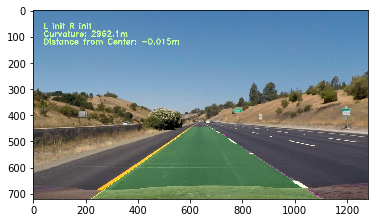

In [536]:
test_img = cv2.imread("test_images/straight_lines1.jpg")
print(test_img.shape)
lane_finder = LaneFinder((720,1280), mask_vertices, anchor_points, tranformed_image_size, 
                         mtx, dist, PIX2XM, PIX2YM, window_width=50, window_height=80, margin=100)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
res = lane_finder.pipeline(test_img)
plt.imshow(res)
mpimg.imsave("out.png", res)

## Test on project video

In [527]:
lane_finder = LaneFinder((720,1280), mask_vertices, anchor_points, tranformed_image_size, 
                         mtx, dist, PIX2XM, PIX2YM, window_width=50, window_height=80, margin=100)

input_vid = 'project_video.mp4'
output = input_vid[:-4]+"_output.mp4"
clip2 = VideoFileClip(input_vid)
# clip2 = clip2.subclip(36)
challenge_clip = clip2.fl_image(lane_finder.pipeline)
%time challenge_clip.write_videofile(output, audio=False)


[MoviePy] >>>> Building video project_video_overlay_polyfinder_curvature_lowpass.mp4
[MoviePy] Writing video project_video_overlay_polyfinder_curvature_lowpass.mp4



 12%|█▏        | 152/1261 [00:22<02:28,  7.46it/s]


 24%|██▍       | 303/1261 [00:45<02:18,  6.89it/s]


 36%|███▌      | 454/1261 [01:06<01:48,  7.41it/s]


 48%|████▊     | 605/1261 [01:27<01:30,  7.28it/s]


 49%|████▉     | 619/1261 [01:29<01:24,  7.58it/s]

failed lane_checker
failed lane_checker
failed lane_checker
failed lane_checker
failed lane_checker



 61%|██████    | 770/1261 [01:50<01:05,  7.53it/s]


 73%|███████▎  | 921/1261 [02:11<00:46,  7.36it/s]


 85%|████████▍ | 1071/1261 [02:32<00:26,  7.06it/s]


 97%|█████████▋| 1219/1261 [02:53<00:05,  7.06it/s]


100%|█████████▉| 1260/1261 [02:59<00:00,  7.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_overlay_polyfinder_curvature_lowpass.mp4 

CPU times: user 3min 14s, sys: 42.5 s, total: 3min 57s
Wall time: 3min


In [125]:
lane_finder = LaneFinder((720,1280), mask_vertices, anchor_points, tranformed_image_size, 
                         mtx, dist, PIX2XM, PIX2YM, window_width=50, window_height=80, margin=100)

input_vid = 'challenge_video.mp4'
output = input_vid[:-4]+"_overlay_polyfinder_curvature.mp4"
clip2 = VideoFileClip(input_vid)
# clip2 = clip2.subclip(36)
challenge_clip = clip2.fl_image(lane_finder.pipeline)
%time challenge_clip.write_videofile(output, audio=False)

In [ ]:
lane_finder = LaneFinder((720,1280), mask_vertices, anchor_points, tranformed_image_size, 
                         mtx, dist, PIX2XM, PIX2YM, window_width=50, window_height=80, margin=100)

input_vid = 'harder_challenge_video.mp4'
output = input_vid[:-4]+"_overlay_polyfinder_curvature.mp4"
clip2 = VideoFileClip(input_vid)
# clip2 = clip2.subclip(36)
challenge_clip = clip2.fl_image(lane_finder.pipeline)
%time challenge_clip.write_videofile(output, audio=False)

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [87]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

Computer Perspective Tranformation

In [148]:
img_size = (800,1280)

def perspective_transformation(target_img_size):
    src = np.array([[592, 453], 
                    [695,453],
                    [970, 630],
                    [348, 630]], dtype = "float32")

    h_margin = 200
    top_margin = 300
    bottom_margin = 50
    dst = np.array([[h_margin, top_margin], 
                    [target_img_size[0] - h_margin, top_margin],
                    [target_img_size[0] - h_margin, target_img_size[1] - bottom_margin],
                    [h_margin, target_img_size[1] - bottom_margin]], dtype = "float32")
    return cv2.getPerspectiveTransform(src, dst)

In [78]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sb = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sb = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sb = np.absolute(sb)
    sc_sb = np.uint8(abs_sb*255/np.max(abs_sb))
    binary_output = np.zeros_like(sc_sb)
    binary_output[(sc_sb>thresh_min)&(sc_sb<thresh_max)]=1
    return binary_output

In [538]:
from moviepy.editor import *

clip = (VideoFileClip("output_videos/project_video_overlay_polyfinder_curvature2.0.mp4")
        .resize(0.2))
clip.speedx(3).write_gif("project_video.gif")


[MoviePy] Building file project_video.gif with imageio



 73%|███████▎  | 308/421 [00:17<00:06, 17.70it/s]


100%|█████████▉| 420/421 [00:24<00:00, 17.81it/s]
